# **Lab 6: Differential Equations**
**Sanskar Gupta**

#**Abstract**
In this notebook following methods will be implemented along with the required unit test cases.

1)Function: Time stepping for scalar initial value problem du/dt = f(u,t)

2)Function: Time stepping for a system of initial value problems du/dt = f(u,t)

3)Function: Simulate a trajectory of a stochastic differential equation dX_t = mu*X_t*dt + sigma*X_t*dW 

In this notebook implicit Euler method will be used for a scalar differential equation and a system of initial value problems.The unit tests will include verfication of accuracy with the exact solution 

#**About the code**

In [71]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Sanskar Gupta (sanskar@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

#**Environment Setup**


In [72]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import newton

#**Methods**

##**Implict Euler method for scalar initial value problem**

\begin{align}
&\frac{du}{dt} = f(u,t) \\ 
&u(0) = u_0
\end{align}
The implicit Euler method is given by algorithm 13.2 in the lecture notes
Following video was referred as well https://youtu.be/Oel1wEFIaDI

For testing following system will be used:
\begin{equation}
\frac{du}{dt} = f(u,t) = \lambda \cdot u(t)
\end{equation}
where we set $\lambda = -1$. This system has the exact solution 
\begin{equation}
u_{exact}(t) = u_0 \cdot \text{e}^{\lambda t}
\end{equation}


In [73]:
def implicitEulerScalar(func, u0, T):
  timestep = 1e-2
  numSteps = round(T/timestep) + 1
  intervals, _ = np.linspace(0, T, num=numSteps, retstep=True)
  u = np.zeros(numSteps)
  u[0] = u0
  i=0;
  for t in (intervals[1:]):
    u[i+1] = newton(lambda x: x - u[i] - timestep*func(x,t), u[i])
    i=i+1
  return intervals, u

In [74]:
def getFunction(c):
  def f(u, t):
    return c*u
  return f

In [75]:
def testImplicitEulerScalar():
    initialValuesArray = np.array([-10, -1, -0.1, 0, 0.1, 1, 10])
    T = 10
    lambdaC = -1
    f = getFunction(lambdaC)
    fig, a = plt.subplots(3, 1, figsize=(14, 12))

    for u0 in initialValuesArray:
        intervals, uApprox = implicitEulerScalar(f, u0, T)
        uExact = u0 * np.exp(lambdaC * intervals)
        rel_error = (uApprox - uExact)
        if not u0 == 0:
            rel_error = rel_error / u0

        a[0].set_title("Plot of approximate solution and exact solution")
        a[0].plot(intervals, uExact, color='green')
        a[1].plot(intervals, uApprox, color='red')

        a[2].set_title('Error of approximate solution')
        a[2].plot(intervals, rel_error)

##**Implicit Euler for system of initial value problems**
\begin{align}
&\frac{du}{dt} = \left( \frac{du_1}{dt}, \dots \frac{du_n}{dt} \right) \\
&u(0) = u_0
\end{align}



Here the following system will be tested

\begin{equation}
\frac{du}{dt} = Au
\end{equation}
with $A = XDX^{-1}$, where
\begin{equation}
D = \begin{bmatrix}
-1 & 0 & 0\\
0 & -2 & 0 \\
0 & 0 & -3
\end{bmatrix}
\end{equation}
and
\begin{equation}
X = \begin{bmatrix}
1/\sqrt{2} & 0 & -1/\sqrt{2}\\
1/\sqrt{2} & 0 & 1/\sqrt{2} \\
0 & 1 & 0
\end{bmatrix}
\end{equation}
which is an orthogonal matrix. Hence we get the exact solution
\begin{equation}
u_{exact}(t) = X \text{e}^{Dt} X^{-1}u_0 = X \begin{bmatrix}
\text{e}^{-1t} & 0 & 0\\
0 & \text{e}^{-2t} & 0 \\
0 & 0 & \text{e}^{-3t}
\end{bmatrix} X^{-1}u_0
\end{equation}.
refrerred from lecture notes equation 14.2
We then calculate the error $e(t) = u_{approx}(t) - u_{exact}(t)$. For each $t$ this will be a vector of length $3$, so we take the norm of this vector and plot it against the time. We do this for a set of different random initial value vectors $u_0$.

In [76]:
def implicitEulerSystem(func, u0, T):
  timestep = 1e-3
  numSteps = round(T/timestep) + 1
  intervals,timestep = np.linspace(0, T, num=numSteps, retstep=True)
  u = np.zeros((u0.size,intervals.size))
  u[:,0] = u0    # setting the first column of U vector with Uo
  i=0;
  for t in (intervals[1:]):
    u[:,i+1] = newton(lambda x: x - u[:, i] - timestep*func(x, t), u[:,i])
    i= i +1
  return u, intervals

In [77]:
def getExactSolution(X,D,u0,intervals):
  u = np.zeros((u0.size, intervals.size))
  d = np.diag(D)
  for i,t in enumerate(intervals):
    u[:,i] = X.dot(np.diag(np.exp(t*d))).dot(np.linalg.inv(X)).dot(u0)
  return u

In [78]:
def testImplicitEulerSystem():
  D = np.diag(np.array([-1,-2,-3]))
  X = np.array([[1/np.sqrt(2), 0, -1/np.sqrt(2)],[1/np.sqrt(2), 0, 1/np.sqrt(2)],[0, 1, 0]])
  A = X.dot(D).dot(np.linalg.inv(X))
  T = 10
  fig, a = plt.subplots(3, 1, figsize=(14, 12))

  for _ in range(5):
    u0 = (np.random.rand(D.shape[0]))
    uApprox, intervals = implicitEulerSystem(lambda x,t: A.dot(x), u0, T)
    uExact = getExactSolution(X, D, u0, intervals)
    error = np.zeros(intervals.size)
    approxNorm = np.zeros(intervals.size)
    exactNorm = np.zeros(intervals.size)
    error = np.linalg.norm(uApprox-uExact, axis=0)
    for i in range(intervals.size):
      approxNorm[i] = np.linalg.norm(uApprox[:,i])
      exactNorm[i] = np.linalg.norm(uExact[:,i])

    a[0].set_title("Plot of the approxNorm of the approximate solution")
    a[0].plot(intervals, approxNorm, color='blue')
    a[1].set_title("Plot of the exactNorm of the approximate solution")
    a[1].plot(intervals, approxNorm, color='green')

    a[2].set_title("Plot of the error uApprox-uExact norm")
    a[2].plot(intervals,error)

##**Trajectory of a stochastic differential equation**
The initial value problem (13.1) can be expressed in differential form as,
$$
du(t) = f(u(t), t)dt, \ \ u(0) = u_0.
$$
In a stochastic differential equation (SDE), we also have a stochastic part of the function, $f(u(t), t)$,
$$
f(u(t), t) = \mu(u(t), t)  + \sigma(u(t),t) \xi_t,
$$
where $\{\xi\}$ is known as a white noise stochastic process, defined by $d W_t = \xi_t dt$ where $d W_t \sim N(0,dt)$, $W_t$ is known as the Wiener process.

This means that we want to find a stochastic process $X_t$ such that,
$$
d X_t = \mu(X_t, t)dt  + \sigma(X_t,t) d W_t, \ \ P(X_0 = u(0)) = 1,
$$
whcih we can write in integral form as,
$$
X_t = X_0 + \int_0^t \mu (X_s, s) ds + \int_0^t \sigma(X_s, s) dW_s.
$$

We use Euler Maruyama method here for the approximation, the result of the method is the approximation of
one observation, or path, x(t) of the stochastic process $X_t$ 
\begin{align*}
x_0 &= u(0), \\
x_n &= x_{n-1} + \mu (x_{n-1}, t_{n-1}) \Delta t_n + \sigma (x_{n-1}, t_{n-1}) \Delta W_n, \\
\Delta t_n &= t_n - t_{n-1}, \\
 \Delta W &= W_{t_n} - W_{t_{n-1}} = Z \sqrt{\Delta t_n}, \ Z \sim N(0,1).
\end{align*}


In [79]:
def eulerMaruyama(mu, sigma, uInitial, T, N):
  deltaT = T/N
  steps = np.zeros(N)
  u = np.zeros(N)
  u[0] = uInitial
  Z = np.random.normal(0, 1, N)
  for i in range(1,N):
    u[i] = u[i-1] + deltaT*mu(u[i-1], deltaT*(i-1)) + sigma(u[i-1], deltaT*(i-1))* Z[i-1]*np.sqrt(deltaT)
    steps[i] = i*deltaT
  return steps, u


To test our Euler-Maruyama implementation we use the Ornstein-Uhlenbeck process (Example 13.9) which models Brownian motion with friction by,
$$
dX_t = -\mu X_t dt + \sigma dW_t, \ \ \mu > 0, \sigma > 0.
$$
Which has an expected value of,
$$
E(X_t) = X_0 e^{-\mu t}.
$$
We use the values,
$$
\mu = 0.5, \ \sigma = 0.3, \ \ X_0 = 10, \ t = 10.
$$
Which gives us the expected value at $t=10$,
$$
E(X_{10}) = 10e^{-5} \approx 0.01347
$$
The method is executed 5k times and some of the trajectory plots are plotted

In [80]:
def testEulerMaruyama():
    mu = lambda u, t: -0.5*u
    sigma = lambda u, t: 0.3
    sum = 0
    number=1000
    numberOfTrajectories=5000
    plt.figure(figsize=(14,8))
    for i in range(10000):
      intervals, u = eulerMaruyama(mu, sigma, 2, 10, number)
      if(i%50==0):
        plt.plot(intervals, u)
      sum += u[number-1]
    plt.xlabel("t")
    plt.ylabel("X_t")
    plt.show()
    print("Appromimate expected value---------------------" + str(sum / 5000))

#**Results**

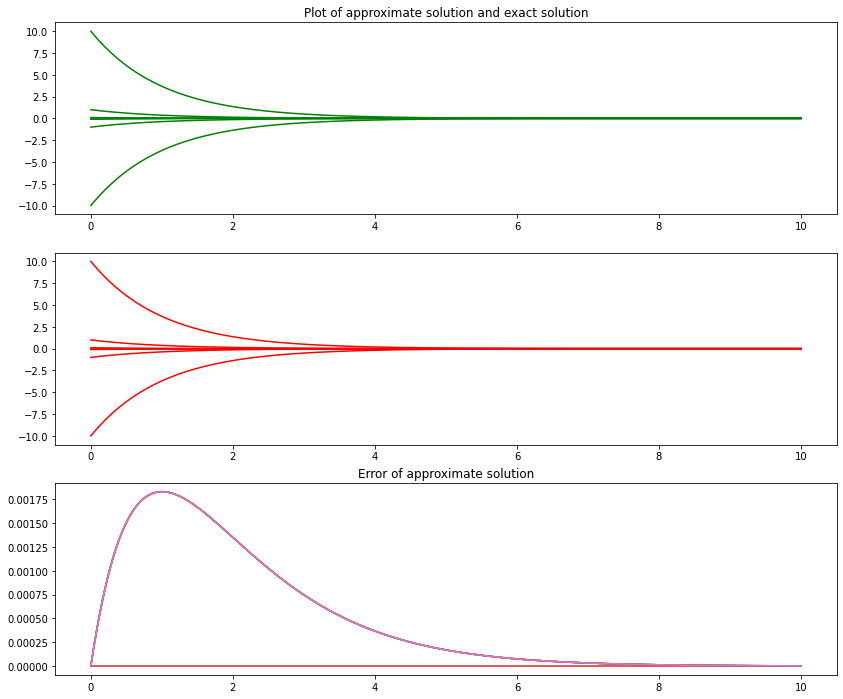

In [81]:
testImplicitEulerScalar()

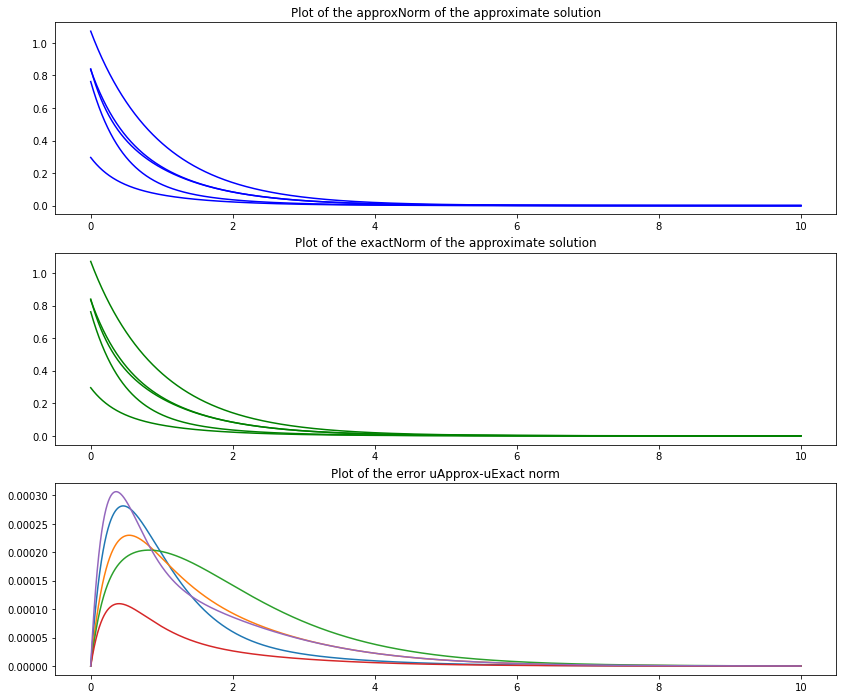

In [82]:
testImplicitEulerSystem()

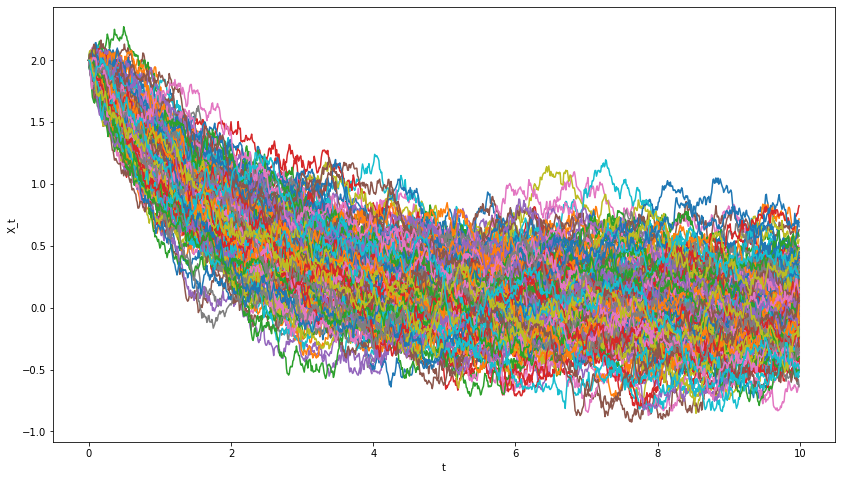

Appromimate expected value---------------------0.024715501765400633


In [83]:
testEulerMaruyama()

#**Discussion**
From the results it can be inferred that imlicit euler time stepping method is stable as error value tends to 0 later.Also it can be noticed that this time stepping method provides accurate solution for scalar as well as system of IVP's

For the SDE the exact expected value is found to be approximately equal to the mean of all the trajectories.